## Cinemática, dinámica y simulación del proyectil

In [2]:
import numpy as np
import random
from math import exp
import matplotlib.pyplot as plt


'''
Funciones esenciales
'''
# Matriz de transformación de coordenadas del sistema inercial al cuerpo
def T_L2B(psi,theta,phi):
    psi = np.radians(psi)
    theta = np.radians(theta)
    phi = np.radians(phi)
    return np.array(
        [
            [np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), np.sin(theta)],
            [-np.sin(psi)*np.sin(theta)*np.cos(phi) - np.cos(psi)*np.sin(phi), -np.sin(psi)*np.sin(theta)*np.sin(phi) + np.cos(psi)*np.cos(phi), np.sin(psi)*np.cos(theta)],
            [np.cos(psi)*np.sin(theta)*np.cos(phi) - np.sin(psi)*np.sin(phi), -np.cos(psi)*np.sin(theta)*np.sin(phi) - np.sin(psi)*np.cos(phi), np.cos(psi)*np.cos(theta)]
        ]
    )

# Matriz de transformación de coordenadas del cuerpo al sistema inercial
def T_B2L(psi,theta,phi):
    psi = np.radians(psi)
    theta = np.radians(theta)
    phi = np.radians(phi)
    return np.array(
        [
            [np.cos(theta)*np.cos(phi), np.cos(psi)*np.sin(theta)*np.cos(phi) - np.sin(psi)*np.sin(phi), np.cos(psi)*np.sin(theta)*np.cos(phi) - np.sin(psi)*np.sin(phi)],
            [np.cos(theta)*np.sin(phi), -np.sin(psi)*np.sin(theta)*np.sin(phi) + np.cos(psi)*np.cos(phi), -np.cos(psi)*np.sin(theta)*np.sin(phi) - np.sin(psi)*np.cos(phi)],
            [np.sin(theta), np.sin(psi)*np.cos(theta), np.cos(psi)*np.cos(theta)]
        ]
    )


# Calculamos el centro de gravedad del proyectil completo
def centro_gravedad(masas, centros_de_gravedad):
    # Aseguramos que masas sea un arreglo columna para poder usar broadcasting correctamente
    masas = masas[:, np.newaxis]
    # Calculamos el centro de gravedad del sistema
    return np.sum(masas * centros_de_gravedad, axis=0) / np.sum(masas)

# Calculamos los momentos de inercia I_xx, I_yy, I_zz
def Momento_inercia(masa, h, r_2, r_1 = 0, dist_a_cm = 0):
    # Momento de inercia de un cilindro de radio exterior r_2, radio interior r_1 y altura h, con centro en su eje de simetría
    I_xx = 1/2*masa*(r_2**2 + r_1**2)**2
    # I_yy = I_zz ya que hay simetría en el eje x
    I_yy = 1/12*masa*(3*(r_2**2 + r_1**2)**2 + h**2) + masa*dist_a_cm**2 # Teorema de Steiner
    I_zz = I_yy
    return np.array([I_xx, I_yy, I_zz])

def der_Momento_inercia(m_dot, h, r_2, r_1 = 0, dist_a_cm = 0):
    # Derivada del momento de inercia respecto al tiempo
    I_xx_dot = 1/2*m_dot*(r_2**2 + r_1**2)**2
    I_yy_dot = 1/12*m_dot*(3*(r_2**2 + r_1**2)**2 + h**2) + m_dot*dist_a_cm**2
    I_zz_dot = I_yy_dot
    return np.array([I_xx_dot, I_yy_dot, I_zz_dot])

def torque(centro_de_gravedad, aplicacion_de_las_fuerzas, fuerzas):
    
    # Calculamos en qué punto se aplican cada una de las fuerzas con respecto al centro de gravedad
    distancias = centro_de_gravedad - aplicacion_de_las_fuerzas
    
    # Calculamos el torque total
    torque_total = np.zeros(3)
    for fuerza, distancia in zip(fuerzas, distancias):
        torque_total += np.cross(distancia, fuerza)
        
    return torque_total

'''
Control PID
'''
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self._last_error = 0
        self._integral = 0
    
    def compute(self, current_value, dt):
        error = self.setpoint - current_value
        self._integral += error * dt
        derivative = (error - self._last_error) / dt
        output = self.Kp * error + self.Ki * self._integral + self.Kd * derivative
        self._last_error = error
        return output


'''
Simulación
'''
def simulacion_proyectil(masas, velocidad, angulos, centros_de_gravedad, radios_cuerpos, alturas_cuerpos, parametros_combustible, tiempo_integracion, parametros_control = [0.0, 0.0, 0.0],trayectoria = 0, escala_ruido = 0, ruido_hist = 0):
    global fuerza_control

    # Definimos las variables locales
    m_parte_sup, m_combustible, m_proyectil = masas
    centro_gravedad_parte_sup, centro_gravedad_combustible, centro_gravedad_proyectil = centros_de_gravedad
    h_parte_sup, h_combustible, h_proyectil = alturas_cuerpos
    r_ext_parte_sup, r_ext_combustible, r_ext_proyectil, r_int_proyectil = radios_cuerpos
    g = 9.81
    
    # Obtenemos los parámetros relacionado a la quema de combustible
    m_dot_combustible, u_relativa, delta_P, A = parametros_combustible
    m_change = m_dot_combustible
    # Angulos con el vector de velocidad
    xy_angle, z_angle = angulos

    # Tamaño de paso
    dt = 0.01

    # Fuerza de empuje
    F_E = m_dot_combustible * u_relativa + delta_P*A

    # Ruido
    ruido = escala_ruido*F_E
    # Calculamos los ángulos de euler
    angulos_euler = np.array([
        [0.0],
        [z_angle],
        [xy_angle]
    ])
    # Velocidad angular
    omega = np.zeros((3,1))
    # Aceleracion angular del sistema
    omega_dot = np.zeros((3,1))

    # Velocidad angular (angulos de euler) (psi_dot, phi_dot, theta_dot
    velocidad_angular = np.zeros((3,1))

    # Vector de velocidad en el sistema inercial
    v_L = np.array([
        [velocidad*np.cos(xy_angle)*np.cos(z_angle)],
        [velocidad*np.sin(xy_angle)*np.cos(z_angle)],
        [velocidad*np.sin(z_angle)]
    ])

    # Posición en el sistema inercial
    p_L = np.zeros((3,1))

    # Posiciones deseadas para el control
    if trayectoria:
        x_c, y_c, z_c = trayectoria
    
    # Inicializamos los controladores PID para cada eje
    pid_x = PID(Kp=parametros_control[0], Ki=parametros_control[1], Kd=parametros_control[2])
    pid_y = PID(Kp=parametros_control[0], Ki=parametros_control[1], Kd=parametros_control[2])
    pid_z = PID(Kp=parametros_control[0], Ki=parametros_control[1], Kd=parametros_control[2])

    # Realizamos la simulación
    x, y, z = [], [], []
    i = 0
    guardar_ruido = []
    while tiempo_integracion > 0:
        psi = angulos_euler[0][0]
        theta = angulos_euler[1][0]
        phi = angulos_euler[2][0]
        
        # Calculo de la masa actual
        if m_combustible - m_dot_combustible*dt >= 0:
            m_combustible -= m_dot_combustible*dt
            m = m_proyectil + m_parte_sup + m_combustible
        else:
            m = m_proyectil + m_parte_sup
            m_change = 0
            F_E = 0
        
        

        '''
        Perturbación
        '''
        # Creamos una fuerza aleatoria de perturbación y el punto donde se aplica si no hay historial de ruido
        if not ruido_hist:
            F_px = random.uniform(-1,1)*ruido
            F_py = random.uniform(-1,1)*ruido
            F_pz = random.uniform(-1,1)*ruido
            # Generamos el punto en el proyectil donde se aplica la fuerza
            r_perturbacion = np.array([random.uniform(0,h_proyectil), 0.0, 0.0])
        else:
            F_px, F_py, F_pz, x_perturbacion = ruido_hist[i]
            r_perturbacion = np.array([x_perturbacion, 0.0, 0.0])
            
        guardar_ruido.append([F_px, F_py, F_pz, r_perturbacion[0]])

        '''
        Control
        '''
        if trayectoria:
            # Ajustamos los setpoints de los PID para el punto actual en la trayectoria
            pid_x.setpoint = x_c[i]
            pid_y.setpoint = y_c[i]
            pid_z.setpoint = z_c[i]

            # Controladores PID para ajustar los ángulos
            control_x = pid_x.compute(p_L[0][0], dt)
            control_y = pid_y.compute(p_L[1][0], dt)
            control_z = pid_z.compute(p_L[2][0], dt)
            
        else: 
            control_x = 0.0
            control_y = 0.0
            control_z = 0.0
        
        # Supondremos que las fuerzas de control se aplican en la base del proyectil
        r_control = np.array([0.0, 0.0, 0.0])

        fuerza_control.append([control_x, control_y, control_z])

        '''
        Dinámica traslacional
        '''
        
        # Calculo de la fuerza en el sistema del cuerpo
        F_B = np.array([
            [F_E + F_px + control_x],
            [F_py + control_y],
            [F_pz + control_z]
        ])
        # Calculo de la fuerza en el sistema inercial sin tomar la gravedad
        F_L = np.dot(T_B2L(psi, theta, phi), F_B)

        # Calculo de la aceleración en el sistema inercial
        a_L = np.array([
            [F_L[0][0]/m],
            [F_L[1][0]/m],
            [(F_L[2][0]-m*g)/m]
        ])

        # Calculo de la velocidad en el sistema inercial
        v_L += a_L*dt

        # Calculo de la posición en el sistema inercial
        p_L += v_L*dt

        # No los utilizamos actualmente ya que no hay viento en el modelo
        a_B = np.dot(T_L2B(psi, theta, phi),a_L)+np.array([
            [omega[2][0]*v_L[1][0]-omega[1][0]*v_L[2][0]],
            [omega[0][0]*v_L[2][0]-omega[2][0]*v_L[0][0]],
            [omega[1][0]*v_L[0][0]-omega[0][0]*v_L[1][0]]
        ])
        v_B = np.dot(T_L2B(psi, theta, phi),v_L)

            
        '''
        Dinámica rotacional
        '''

        # Calculamos la posición del centro de gravedad
        cm = centro_gravedad(np.array([m_parte_sup, m_combustible, m_proyectil]), np.array([centro_gravedad_parte_sup, centro_gravedad_combustible, centro_gravedad_proyectil]))
        
        # Calculamos las posiciones del centro de gravedad de cada parte con respecto al centro de gravedad del sistema
        dist_cm_parte_sup = centro_gravedad_parte_sup[0] - cm[0]
        dist_cm_combustible = centro_gravedad_combustible[0] - cm[0]
        dist_cm_proyectil = centro_gravedad_proyectil[0] - cm[0]
        
        # Calculamos el momento de inercia total de las 3 masas
        I_parte_sup = Momento_inercia(m_parte_sup, h_parte_sup, r_ext_parte_sup, dist_a_cm=dist_cm_parte_sup)
        I_combustible = Momento_inercia(m_combustible, h_combustible, r_ext_combustible, dist_a_cm=dist_cm_combustible)
        I_proyectil = Momento_inercia(m_proyectil, h_proyectil, r_ext_proyectil, r_int_proyectil, dist_a_cm=dist_cm_proyectil)
        I_xx = I_parte_sup[0] + I_combustible[0] + I_proyectil[0]
        I_yy = I_parte_sup[1] + I_combustible[1] + I_proyectil[1]
        I_zz = I_parte_sup[2] + I_combustible[2] + I_proyectil[2]

        # Derivamos los momentos de inercia respecto al tiempo, la masa cambia por lo cual dm/dt = m_dot
        I_dot_parte_sup = [0.0,0.0,0.0] # La masa no varía
        I_dot_combustible = der_Momento_inercia(m_change, h_combustible, r_ext_combustible, dist_a_cm=dist_cm_combustible)
        I_dot_proyectil = [0.0,0.0,0.0] # La masa no varía
        I_xx_dot = I_dot_parte_sup[0] + I_dot_combustible[0] + I_dot_proyectil[0]
        I_yy_dot = I_dot_parte_sup[1] + I_dot_combustible[1] + I_dot_proyectil[1]
        I_zz_dot = I_dot_parte_sup[2] + I_dot_combustible[2] + I_dot_proyectil[2]
    
        # El torque debido al peso es cero
        M_total = [0.,0.,0.] 
        
        # Calculamos el torque debido a la fuerza de perturbacion y al control
        Torque_pyc = torque(cm, np.array([r_perturbacion, r_control]), np.array([[F_px, F_py, F_pz], [control_x, control_y, control_z]]))
        
        # Calculamos el torque total
        M_x = M_total[0] + Torque_pyc[0]
        M_y = M_total[1] + Torque_pyc[1]
        M_z = M_total[2] + Torque_pyc[2]
        
        # Calculamos la aceleración angular
        omega_dot = np.array([
            [((I_yy - I_zz)*omega[1][0]*omega[2][0] - I_xx_dot*omega[0][0] + M_x)/I_xx],
            [((I_zz - I_xx)*omega[0][0]*omega[2][0] - I_yy_dot*omega[1][0] + M_y)/I_yy],
            [((I_xx - I_yy)*omega[0][0]*omega[1][0] - I_zz_dot*omega[2][0] + M_z)/I_zz]
        ])
        
        # Actualizamos la velocidad angular (método de Euler)
        omega += omega_dot*dt
        
        # Calculamos la velocidad angular en el sistema de cuerpo
        velocidad_angular = np.array([
            [omega[0][0] - omega[1][0]*np.sin(psi)*np.tan(theta) - omega[2][0]*np.cos(psi)*np.tan(theta)],
            [omega[1][0]*np.cos(psi) - omega[2][0]*np.sin(psi)],
            [-omega[1][0]*np.sin(psi)/np.cos(theta) + omega[2][0]*np.cos(psi)/np.cos(theta)]
        ])
        
        # Actualizamos los angulos de Euler (método de Euler)
        angulos_euler += velocidad_angular*dt

        # Guardamos las posiciones actuales
        x.append(p_L[0][0])
        y.append(p_L[1][0])
        z.append(p_L[2][0])

        # if p_L[2][0] < 0:
        #     break
        
        tiempo_integracion -= dt
        i += 1
    return x, y, z, guardar_ruido


## Condiciones iniciales

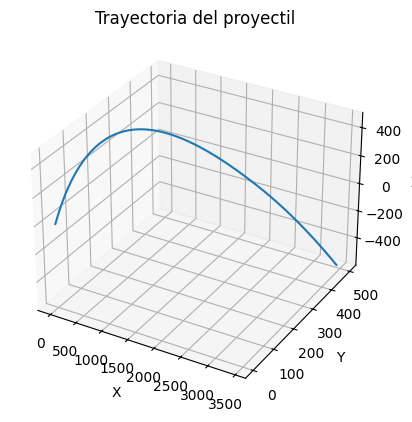

In [3]:
# Masa de cada componente
m_parte_sup = 1.0
m_combustible = 2.0
m_proyectil = 1.0

# Agregamos las masas en un arreglo
masas = [m_parte_sup, m_combustible, m_proyectil]

# Tasa de perdida de masa del combustible
m_dot_combustible = 0.1

# Gravedad
g = 9.81

# Centro de gravedad inicial respecto a la base del proyectil
centro_gravedad_parte_sup = np.array([1.5, 0.0, 0.0])
centro_gravedad_combustible = np.array([0.5, 0.0, 0.0])
centro_gravedad_proyectil = np.array([1.0, 0.0, 0.0])

# Agregamos los centros de gravedad en un arreglo
centros_de_gravedad = [centro_gravedad_parte_sup, centro_gravedad_combustible, centro_gravedad_proyectil]

# Altura de cada parte
h_parte_sup = 1.0
h_combustible = 1.0
h_proyectil = 2.0

# Agregamos las alturas en un arreglo
alturas_cuerpos = [h_parte_sup, h_combustible, h_proyectil]

# Radios de cada parte
r_ext_parte_sup = 0.1
r_ext_combustible = 0.1
r_ext_proyectil = 0.2
r_int_proyectil = 0.15

# Agregamos los radios en un arreglo
radios_cuerpos = [r_ext_parte_sup, r_ext_combustible, r_ext_proyectil, r_int_proyectil]

# Escala de ruido (en porcentaje del empuje)
escala_ruido = 0.20

# Velocidad de la masa eyectada
u_relativa = 10.0
# Diferencia de presión en Pa
delta_P = 1000.0
# Area de la tobera
A = 0.03
# Agregamos los parámetros del combustible en un arreglo
parametros_combustible = [m_dot_combustible, u_relativa, delta_P, A]

# Magnitud de la velocidad de traslación
velocidad = 100.0
# Angulos iniciales
xy_angle = np.radians(45)
z_angle = np.radians(75)
# Agregamos los angulos en un arreglo
angulos = [xy_angle, z_angle]

# Tiempo de integración
tiempo_integracion = 25.0

fuerza_control = []
# Posiciones del proyectil y ruido (en este caso es 0 ya que no añadimos ruido a la trayectoria original)
x_p, y_p, z_p, ruido = simulacion_proyectil(masas, velocidad, angulos, centros_de_gravedad, radios_cuerpos, alturas_cuerpos, parametros_combustible, tiempo_integracion, escala_ruido=0.0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_p, y_p, z_p, label='Trayectoria')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trayectoria del proyectil')
plt.show()

In [162]:
3.1416*(0.1**2)

0.031416000000000006

## Trayectoria del proyectil sin control con perturbación

In [4]:
# Podemos cargar la perturbación de ruido para la simulación
ruido_hist = np.loadtxt('Ruido_sim_1.txt', delimiter=',').tolist()

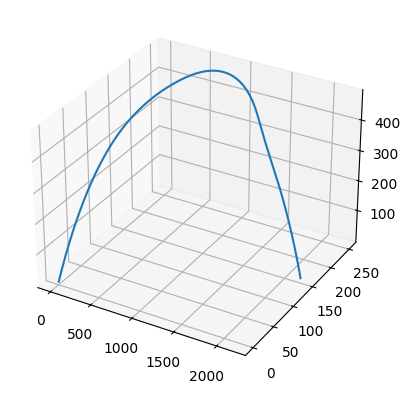

In [5]:
fuerza_control = []
# Ruido
#ruido_hist = 0
# Coordenadas y ruido en la trayectoria
x_con_pert, y_con_pert, z_con_pert, ruido_aux = simulacion_proyectil(masas, velocidad, angulos, centros_de_gravedad, radios_cuerpos, alturas_cuerpos, parametros_combustible, tiempo_integracion, escala_ruido=0.2, ruido_hist=ruido_hist)
# Limitamos a solo valores positivos en z
j = 0
for z in z_con_pert:
    if z < 0:
        break
    j += 1
x_con_pert = x_con_pert[:j-1]
y_con_pert = y_con_pert[:j-1]
z_con_pert = z_con_pert[:j-1]
# Graficamos
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_con_pert, y_con_pert, z_con_pert, label='Trayectoria con perturbación')

In [208]:
# Guardamos la perturbación en un archivo txt para cargarla posteriormente
np.savetxt('Ruido_sim_1.txt', ruido_aux, delimiter=',')

## Trayectoria del proyectil con control y perturbación

Text(0.5, 0.92, 'Trayectoria del proyectil')

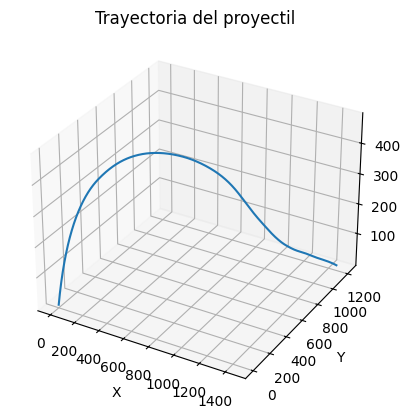

In [6]:
# Añadimos la trayectoria a seguir
trayectoria = [x_p, y_p, z_p]
# Cargamos el archivo de ruido si lo tenemos
ruido_hist = np.loadtxt('Ruido_sim_1.txt', delimiter=',')
# Convertimos a una lista
ruido_hist = ruido_hist.tolist()
# Parámetros del controlador PID (Kp, Ki, Kd)
parametros_control = [0.05, 0.01, 0.01]
# Arreglo donde guardaremos las fuerzas de control
fuerza_control = []
# Posiciones del proyectil con control
x_con_control, y_con_control, z_con_control, aux = simulacion_proyectil(masas, velocidad, angulos, centros_de_gravedad, radios_cuerpos, alturas_cuerpos, parametros_combustible, tiempo_integracion, parametros_control,trayectoria=trayectoria, escala_ruido=escala_ruido, ruido_hist=ruido_hist)

# Limitamos a solo valores positivos en z
j = 0
for z in z_con_control:
    if z < 0:
        break
    j += 1
x_con_control = x_con_control[:j-1]
y_con_control = y_con_control[:j-1]
z_con_control = z_con_control[:j-1]
# Grafica de la trayectoria
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_con_control, y_con_control, z_con_control, label='Trayectoria')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trayectoria del proyectil')


## Fuerzas de control

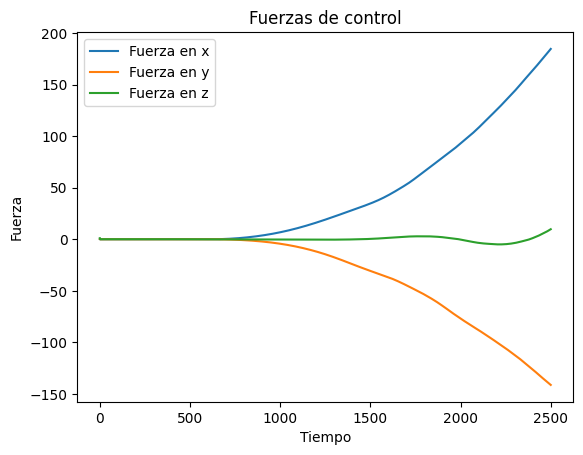

In [7]:
# Grafi1camos las fuerzas de control
fig = plt.figure()
ax = fig.add_subplot(111)
fuerza_control = np.array(fuerza_control)
ax.plot(range(len(fuerza_control)), fuerza_control[:,0], label='Fuerza en x')
ax.plot(range(len(fuerza_control)), fuerza_control[:,1], label='Fuerza en y')
ax.plot(range(len(fuerza_control)), fuerza_control[:,2], label='Fuerza en z')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Fuerza')
ax.set_title('Fuerzas de control')
ax.legend()

## Comparativo de trayectorias

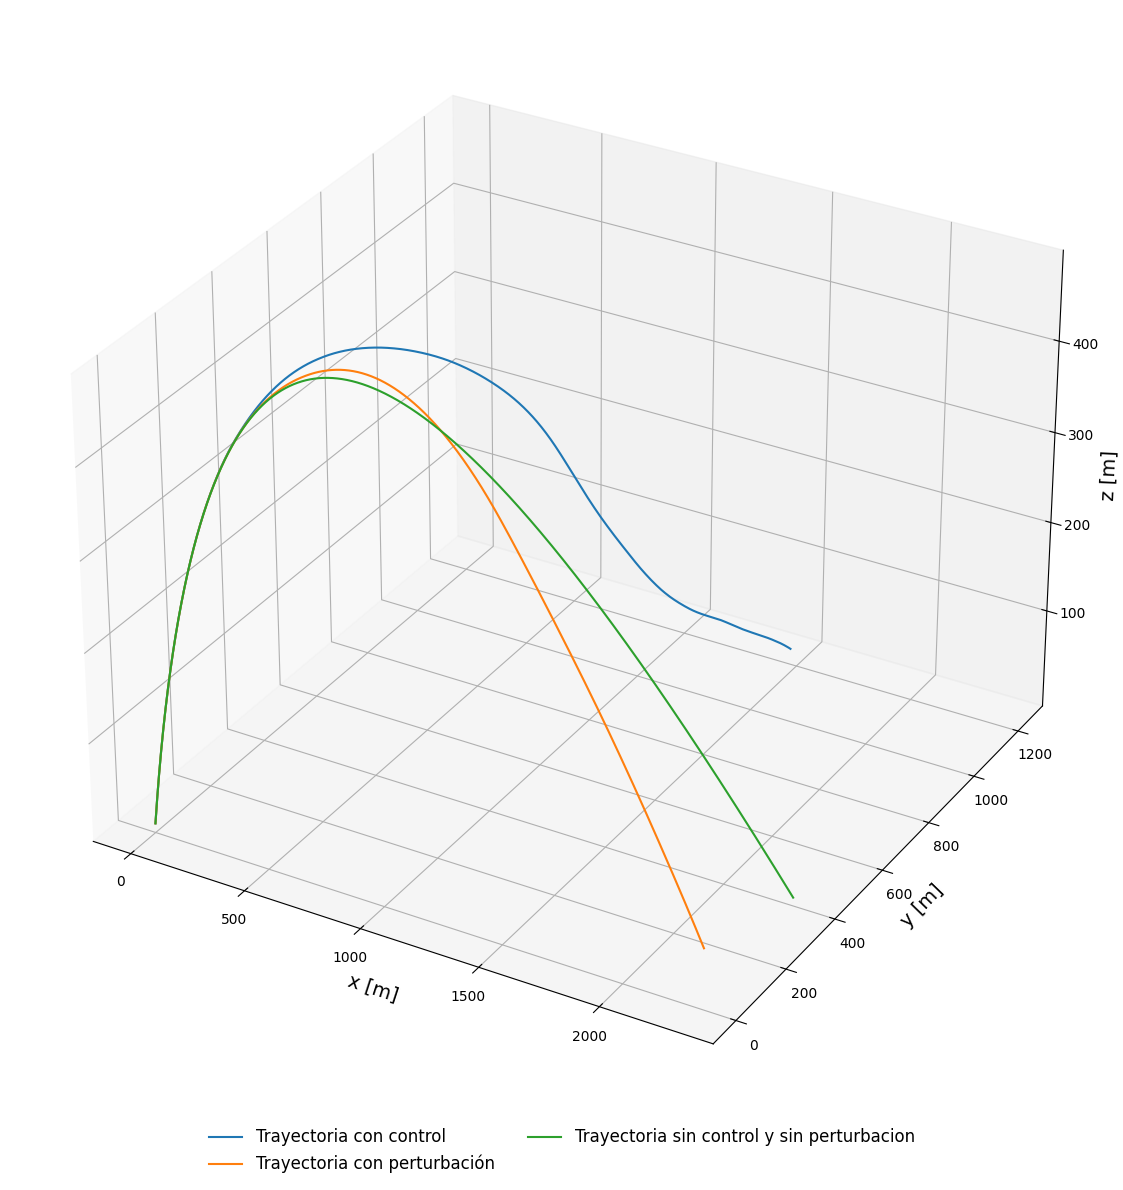

In [9]:
j = 0
for z in z_p:
    if z < 0:
        break
    j += 1
x_p_copia = x_p[:j-1]
y_p_copia = y_p[:j-1]
z_p_copia = z_p[:j-1]
# Comparamos las trayectorias con control y perturbacion y la solo perturbada
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_con_control, y_con_control, z_con_control, label='Trayectoria con control')
ax.plot(x_con_pert, y_con_pert, z_con_pert, label='Trayectoria con perturbación')
ax.plot(x_p_copia, y_p_copia, z_p_copia, label='Trayectoria sin control y sin perturbacion')
ax.set_xlabel('x [m]', fontsize=14)
ax.set_ylabel('y [m]', fontsize=14)
ax.set_zlabel('z [m]', fontsize=14)
#ax.set_title('Trayectoria del proyectil')
# Aumentamos el tamaño de la figura
fig.set_size_inches(12,12)
# Movemos la caja de las leyendas a la parte inferior
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0), shadow=False, ncol=2, frameon=False, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout()
plt.show()

## Errores

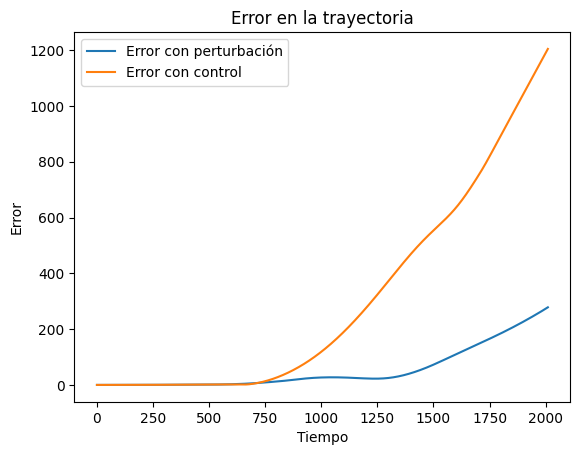

In [10]:
indice = min(len(x_p_copia), len(x_con_pert), len(x_con_control))
# Calculamos cual es el error a lo largo de la trayectoria
error_pert = np.sqrt((np.array(x_p_copia[:indice]) - np.array(x_con_pert[:indice]))**2 + (np.array(y_p_copia[:indice]) - np.array(y_con_pert[:indice]))**2 + (np.array(z_p_copia[:indice]) - np.array(z_con_pert[:indice]))**2)
error_control = np.sqrt((np.array(x_p_copia[:indice]) - np.array(x_con_control[:indice]))**2 + (np.array(y_p_copia[:indice]) - np.array(y_con_control[:indice]))**2 + (np.array(z_p_copia[:indice]) - np.array(z_con_control[:indice]))**2)

# Calculamos el error promedio
error_promedio_pert = np.mean(error_pert)
error_promedio_control = np.mean(error_control)

# Graficamos el error
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(indice), error_pert, label='Error con perturbación')
ax.plot(range(indice), error_control, label='Error con control')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Error')
ax.set_title('Error en la trayectoria')
ax.legend()

## Búsqueda de parámetros de control

In [38]:
import random
from math import exp
# Buscaremos los mejores parámetros de control utilizando el algoritmo de recodido simulado
# La función a minimizar en este caso es el error cuadrático medio entre la trayectoria con control y la trayectoria deseada
# Definimos la función de costo
def costo(x, y, z, x_d, y_d, z_d):
    # Convertimos las listas a numpy
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    x_d = np.array(x_d)
    y_d = np.array(y_d)
    z_d = np.array(z_d)
    return np.mean((x - x_d)**2 + (y - y_d)**2 + (z - z_d)**2)

# Definimos la función de aceptación
def recocido_simulado(parametros_control, x_con_control, y_con_control, z_con_control, x_p, y_p, z_p, T, T_min, alpha, indice):
    s_0 = costo(x_con_control, y_con_control, z_con_control, x_p, y_p, z_p)
    parametros_s0 = parametros_control
    fuerza_control = []
    while T > T_min:
        # No perturbaremos todos los parámetros al mismo tiempo, primero perturbaremos el primer parámetro[0] y veamos si mejora, si no, perturbaremos el segundo parámetro[1] y así sucesivamente
        for i in range(3):
            parametros_s_n = parametros_s0.copy()
            parametros_s_n[i] = random.uniform(0, 10)
            x_con_control, y_con_control, z_con_control, aux = simulacion_proyectil(masas, velocidad, angulos, centros_de_gravedad, radios_cuerpos, alturas_cuerpos, parametros_combustible, tiempo_integracion, parametros_s_n,trayectoria=trayectoria, escala_ruido=escala_ruido, ruido_hist=ruido_hist) 
            s_n = costo(x_con_control[:indice], y_con_control[:indice], z_con_control[:indice], x_p, y_p, z_p)
            delta_E = s_n - s_0
            if delta_E <= 0:
                s_0 = s_n
                parametros_s0 = parametros_s_n.copy()
            else:
                if random.random() < exp(-delta_E/T):
                    s_0 = s_n
                    parametros_s0 = parametros_s_n.copy()
        T *= alpha
    return s_0, parametros_s0

indice = min(len(x_p_copia), len(x_con_control))
fuerza_control = []
error, nuevos_parametros_control, = recocido_simulado(parametros_control, x_con_control[:indice].copy(), y_con_control[:indice].copy(), z_con_control[:indice].copy(), x_p[:indice].copy(), y_p[:indice].copy(), z_p[:indice].copy(), 100, 0.01, 0.9, indice)

In [48]:
nuevos_parametros_control

[0.05, 0.01, 0.5966572602385289]

## Evaluacion de la funcion de costo

In [61]:
# Calculamos el costo entre la trayectoria perturbada y la deseada
error = costo(x_con_pert[:indice], y_con_pert[:indice], z_con_pert[:indice], x_p[:indice], y_p[:indice], z_p[:indice])
error

3354.3649323863087

In [62]:
# Calculamos el costo entre la trayectoria con control y la deseada
x_con_control, y_con_control, z_con_control, aux = simulacion_proyectil(masas, velocidad, angulos, centros_de_gravedad, radios_cuerpos, alturas_cuerpos, parametros_combustible, tiempo_integracion, nuevos_parametros_control,trayectoria=trayectoria, escala_ruido=escala_ruido, ruido_hist=ruido_hist)
error = costo(x_con_control[:indice], y_con_control[:indice], z_con_control[:indice], x_p[:indice], y_p[:indice], z_p[:indice])
error

21.13877117468165

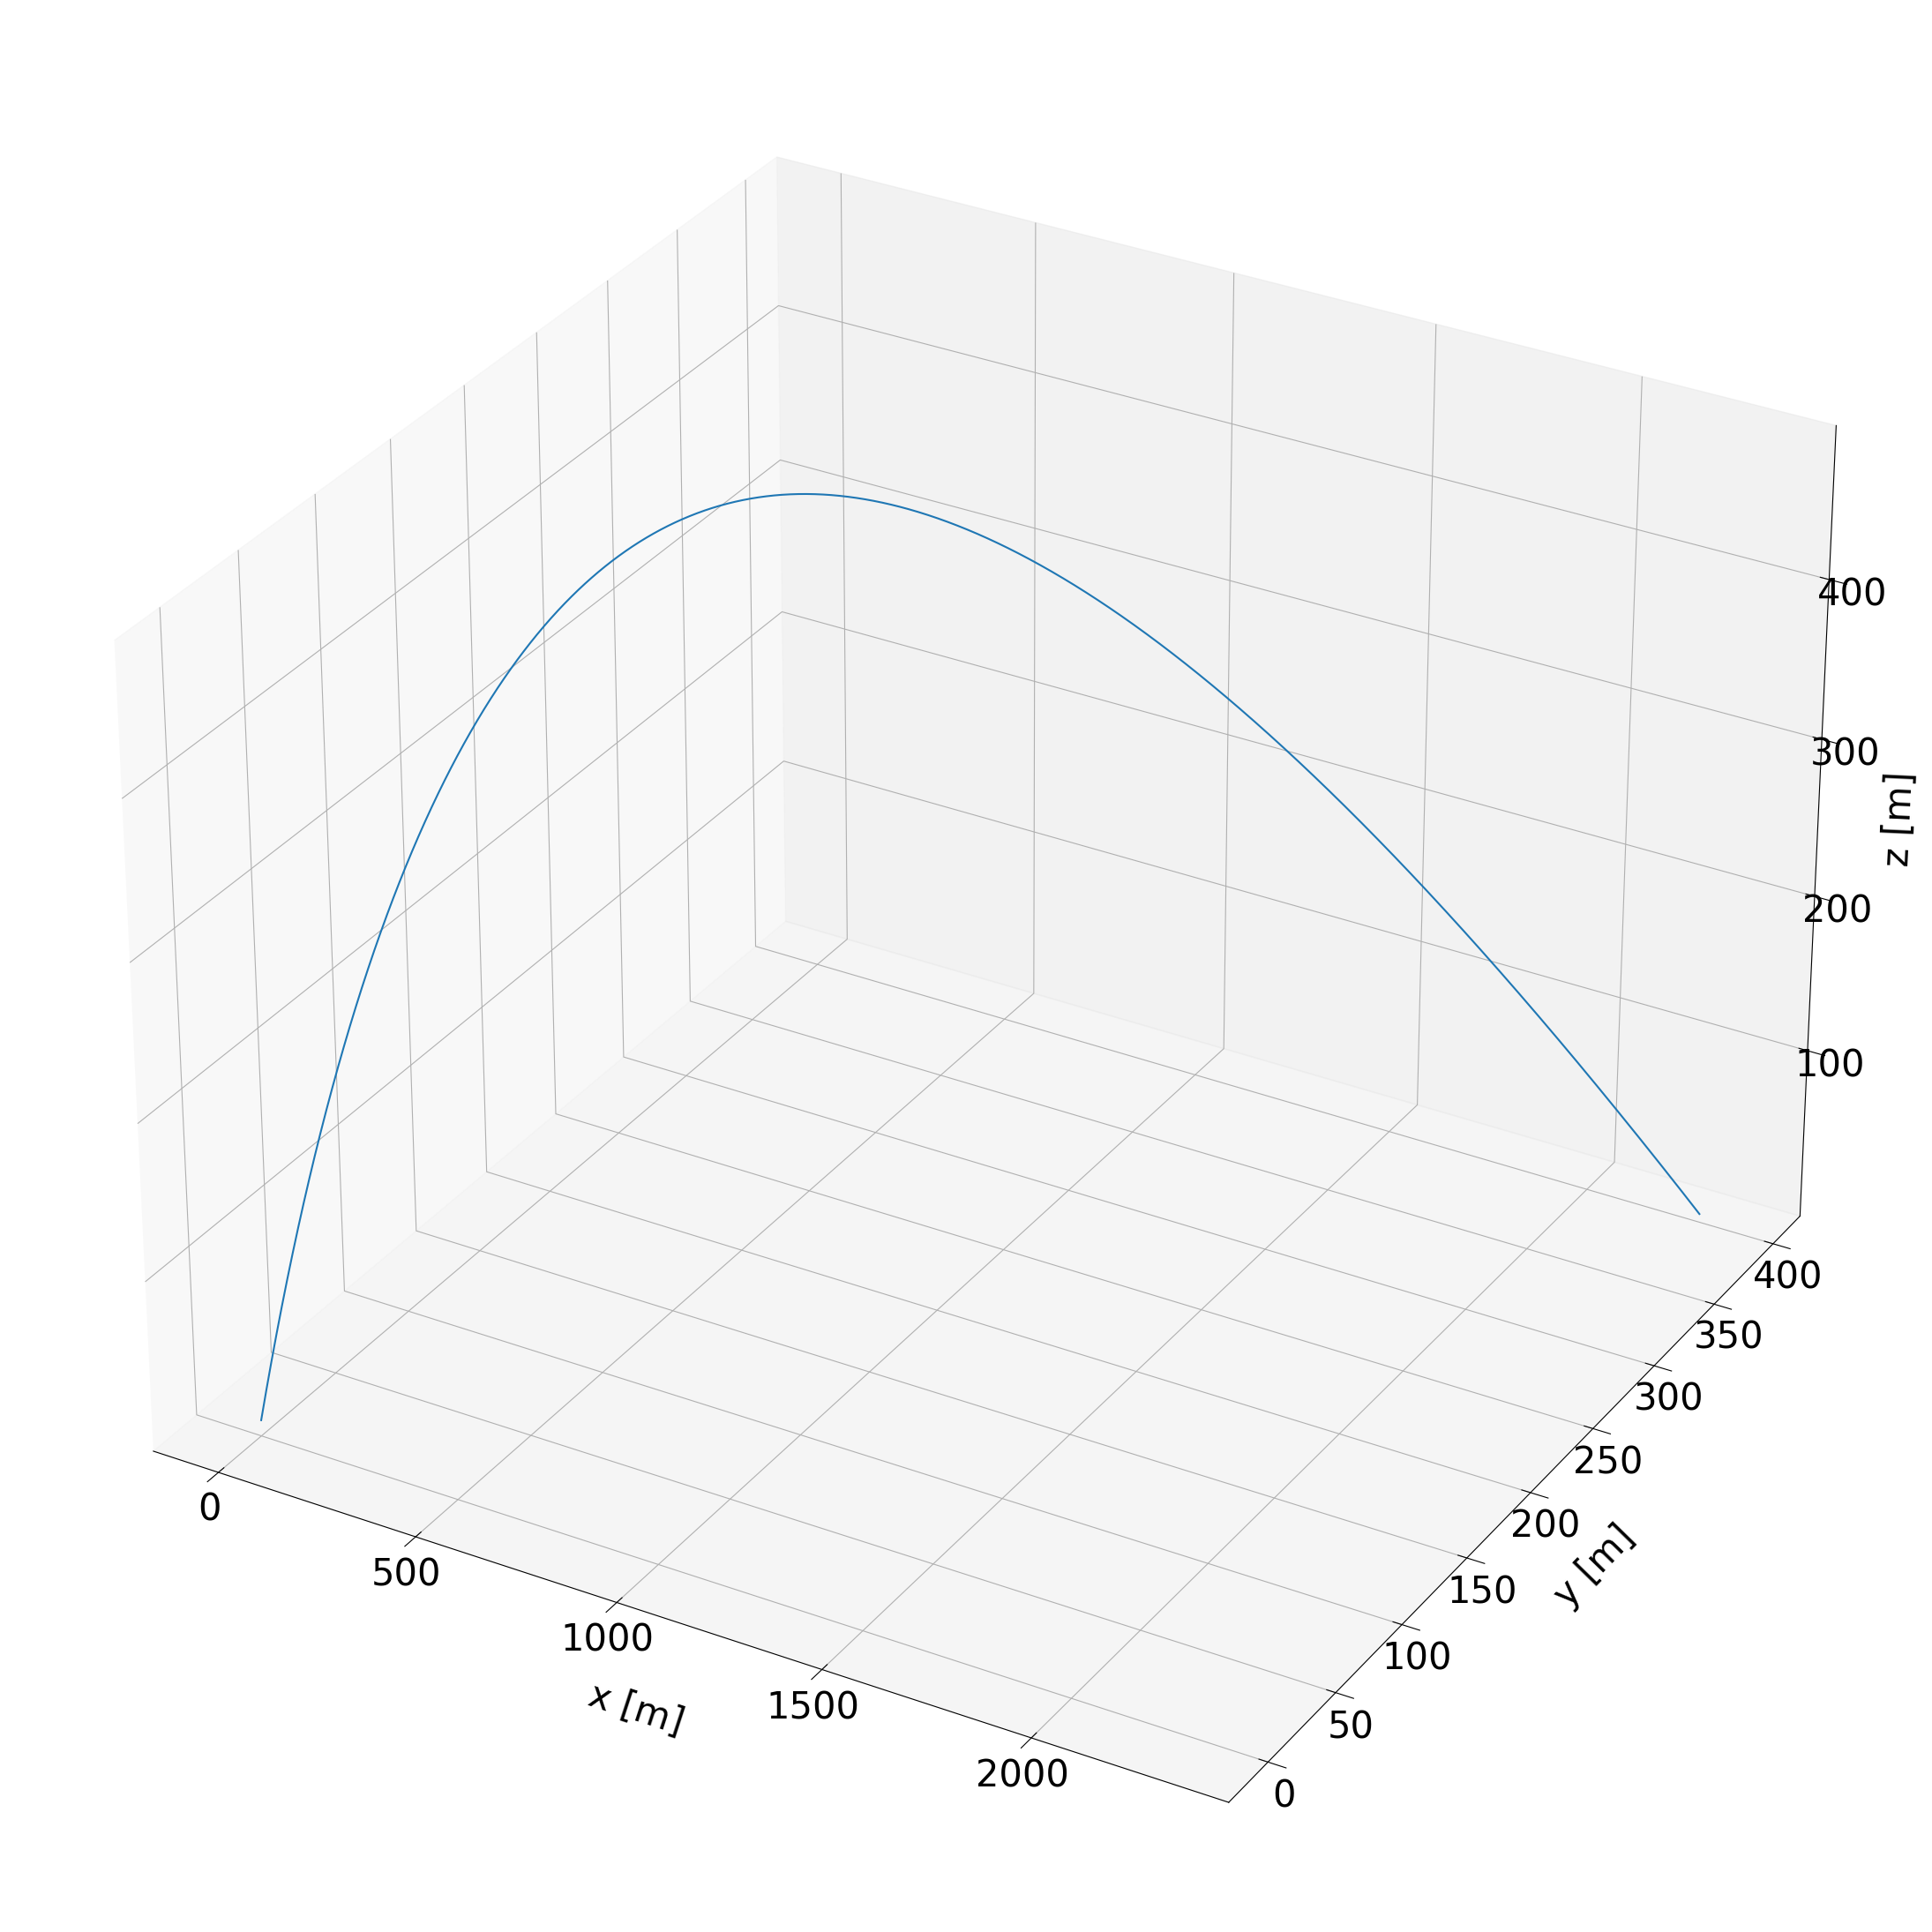

In [59]:
fuerza_control = []
# nuevos_parametros_control = [0.01, 0.05, 0.005]
x_con_control, y_con_control, z_con_control, aux = simulacion_proyectil(masas, velocidad, angulos, centros_de_gravedad, radios_cuerpos, alturas_cuerpos, parametros_combustible, tiempo_integracion, nuevos_parametros_control,trayectoria=trayectoria, escala_ruido=escala_ruido, ruido_hist=ruido_hist)
j = 0
for z in z_con_control:
    if z < 0:
        break
    j += 1
x_con_control = x_con_control[:j-1]
y_con_control = y_con_control[:j-1]
z_con_control = z_con_control[:j-1]
# Comparamos las trayectorias con control y perturbacion y la solo perturbada
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_p_copia, y_p_copia, z_p_copia, label='Trayectoria sin control y sin perturbacion')
#ax.plot(x_con_pert, y_con_pert, z_con_pert, label='Trayectoria con perturbación')
#ax.plot(x_con_control, y_con_control, z_con_control, label='Trayectoria con control y perturbación')
ax.set_xlabel('x [m]', fontsize=30, labelpad=30)
ax.set_ylabel('y [m]', fontsize=30, labelpad=30)
ax.set_zlabel('z [m]', fontsize=30, labelpad=20)

#ax.set_title('Trayectoria del proyectil')
# Aumentamos el tamaño de la figura
fig.set_size_inches(22,22)
# Movemos la caja de las leyendas a la parte inferior
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0), shadow=False, ncol=3, frameon=False, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=30)


plt.tight_layout()
#plt.savefig('Trayectoria1_con_perturbacion_y_control.png')
#plt.savefig('Trayectoria1_con_perturbacion.png')
plt.savefig('Trayectoria1_sin_perturbacion.png')
plt.show()

Parametros control tesis

In [43]:
nuevos_parametros_control = [0.05, 0.01, 0.5966572602385289]